## Boosting and Stacking 

## Objectives

*   Understand how Gradient Boosting helps reduce error
*   Identify the benefits of using AdaBoost
*   Interpret the benefits of stacking models and comparing their results to boosted models


## Introduction

We will be using the Human Activity Recognition with Smartphones database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
*   Triaxial angular velocity from the gyroscope.
*   A 561-feature vector with time and frequency domain variables.
*   Its activity label.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

*   Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
*   Determine if the float columns need to be scaled.


In [2]:
data = pd.read_csv("Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

In [3]:
data.head()

,Unnamed: 0,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


The data has quite a few predictor columns.


In [4]:
data.shape

(10299, 563)

And they're all float values. The only non-float is the categories column, which is being predicted.


In [5]:
data.dtypes.value_counts()

float64    561
int64        1
object       1
Name: count, dtype: int64

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.


In [6]:
# Mask to select float columns
float_columns = (data.dtypes == float)

print( (data.loc[:,float_columns].max()==1.0).all() )
print( (data.loc[:,float_columns].min()==-1.0).all() )

True
True


*   Integer encode the activities.
*   Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [8]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.


In [9]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)


In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 562), (7209,), (3090, 562), (3090,))

*   Fit gradient boosted tree models with all parameters set to their defaults with the following tree numbers (`n_estimators = [5, 10, 15, 25, 50]`) and evaluate the accuracy on the test data for each of these models.
*   Plot the accuracy as a function of estimator number.

*Note:* there is no out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.


In [11]:
tree_list = [5, 10, 15, 25, 50]

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [12]:
error_list = list()

# Iterate through various possibilities for number of trees
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 5 trees
Fitting model with 10 trees
Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees


,error
n_trees,
5.0,0.066990
10.0,0.059871
15.0,0.051133
25.0,0.033333
50.0,0.020065


Now plot the result.


(0.0, 55.00000000000001)

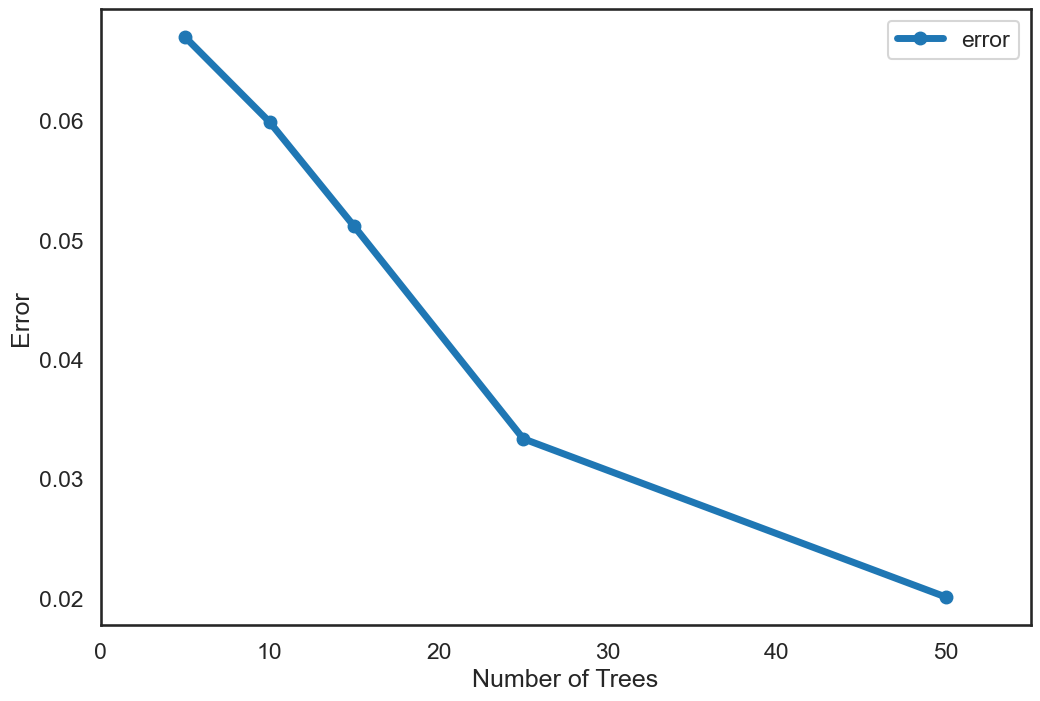

In [13]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1)

*   Using a grid search with cross-validation, fit a new gradient boosted classifier with the same list of estimators as question 3. Also try varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
*   Examine the parameters of the best fit model.
*   Calculate relevant error metrics on this model and examine the confusion matrix.


In [14]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy')

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [15]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=50, random_state=42)

The error metrics. Classification report is particularly convenient for multi-class cases.


In [16]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       599
           1       0.90      0.94      0.92       540
           2       0.94      0.91      0.92       566
           3       0.99      0.99      0.99       541
           4       0.95      0.98      0.96       406
           5       0.97      0.94      0.96       438

    accuracy                           0.96      3090
   macro avg       0.96      0.96      0.96      3090
weighted avg       0.96      0.96      0.96      3090



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.


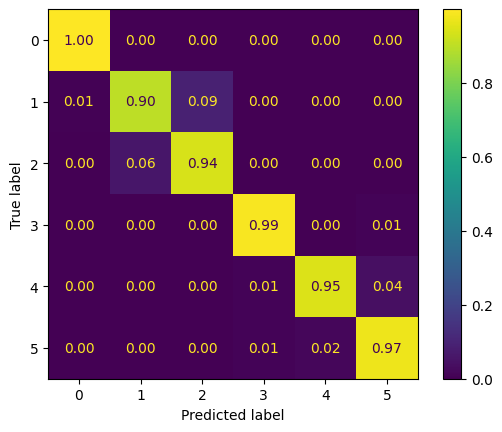

In [17]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=GV_GBC.classes_)
disp.plot(values_format='.2f')
plt.show()

*   Create an AdaBoost model and fit it using grid search. Try a range of estimators between 20 and 50.
*   Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [20, 30, 50],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy')

GV_ABC = GV_ABC.fit(X_train, y_train)

The best model.


In [21]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.


In [22]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.01      1.00      0.01         3
           2       1.00      0.49      0.66      1106
           3       0.97      0.55      0.70       950
           4       0.77      0.91      0.83       355
           5       0.08      0.41      0.13        78

    accuracy                           0.65      3090
   macro avg       0.64      0.73      0.56      3090
weighted avg       0.94      0.65      0.74      3090



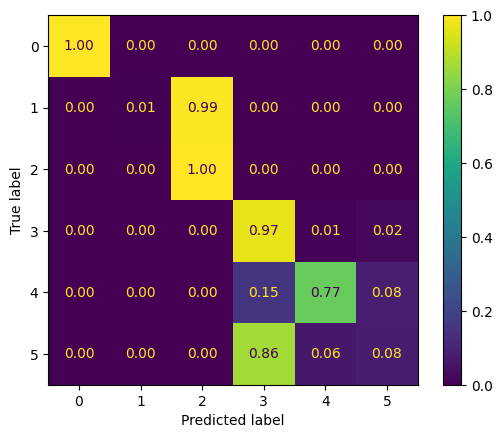

In [23]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=GV_ABC.classes_)
disp.plot(values_format='.2f')
plt.show()

*   Fit a logistic regression model with regularization.
*   Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both)
*   Determine the error as before and compare the results to the appropriate gradient boosted model(s).
*   Plot the confusion matrix for the best model created in this set of exercises.

In [24]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.


In [25]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       696
           1       0.00      0.00      0.00         0
           2       1.00      0.42      0.59      1310
           3       0.69      0.60      0.64       623
           4       0.20      0.90      0.33        94
           5       0.65      0.75      0.69       367

    accuracy                           0.61      3090
   macro avg       0.59      0.59      0.53      3090
weighted avg       0.87      0.61      0.68      3090



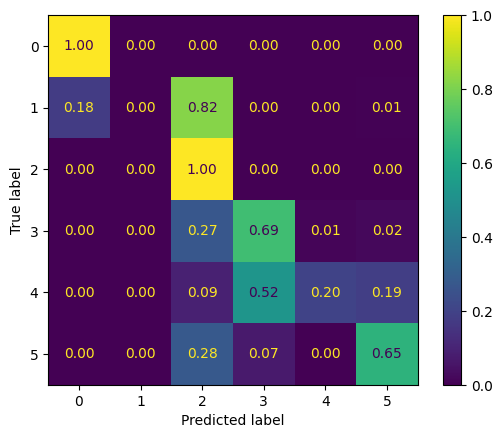

In [26]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=LR_L2.classes_)
disp.plot(values_format='.2f')
plt.show()

And now the stacked model.


In [27]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.


In [28]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       597
           1       0.95      0.89      0.92       563
           2       0.90      0.95      0.93       547
           3       0.99      0.99      0.99       539
           4       0.98      0.95      0.96       420
           5       0.94      0.97      0.96       424

    accuracy                           0.96      3090
   macro avg       0.96      0.96      0.96      3090
weighted avg       0.96      0.96      0.96      3090



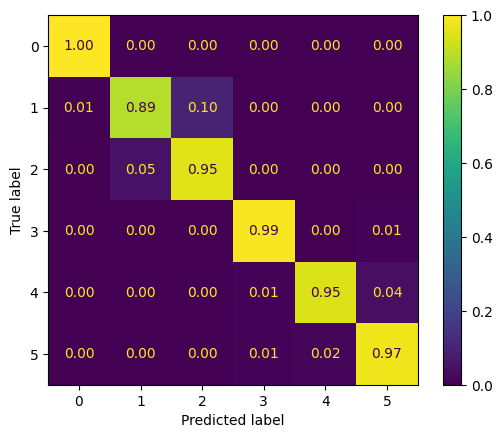

In [29]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=VC.classes_)
disp.plot(values_format='.2f')
plt.show()
#sns.set_context('talk')
#cm = confusion_matrix(y_test, y_pred)
#ax = sns.heatmap(cm, annot=True, fmt='d')